# Optimizating Law Enforcement Response in New Delhi
## Final Project | CS 166 | Prof. Drummond
### Anirudh Nair

# Introduction

### Thesis
Through the following model, I aim to optimize the placement of PCR Vans (Police Control Room Vans) in the city of Delhi so that in the event of a crime, the PCR vans are able to respond to the situation immedietely in the most optimal way possible. 

### Descrpiption of the Situation
Delhi has one of the highest rates of crime accross all cities in India. In Delhi, the police usually relies on radio communication and a team of vans spread out around the city to spot criminals in the city. However, with the advent of technology and cheap access to mobile phones, I believe law enforcement in Delhi can be optimized with the help of modelling and simulation.

In [114]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import networkx as nx
import random
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from descartes import PolygonPatch
from random import random, choice
import os

sns.set()

In [5]:
import osmnx as ox

In [6]:
delhi = "New Delhi, India"
graph = ox.graph_from_place(delhi, network_type='drive')

In [7]:
G_nx = nx.relabel.convert_node_labels_to_integers(graph)

In [8]:
fig, ax = ox.plot_graph(G_nx)

In [9]:
G_nx.number_of_nodes()

9298

In [10]:
G_nx.number_of_edges()

22857

In [11]:
nx.density(G_nx)

0.0002644154669062127

In [12]:
nx.average_shortest_path_length(G_nx)

45.95376357132021

In [13]:
nc = ['b' if ox.is_endpoint(G_nx, node) else 'r' for node in G_nx.nodes()]
fig, ax = ox.plot_graph(G_nx, node_color=nc, node_zorder=3)

In [14]:
# calculate the extended network stats to get access to the array which includes
# the betweenness centrality value for each node in the network
extended_stats = ox.extended_stats(G_nx, ecc=True, bc=True, cc=True)

In [15]:
projected = ox.project_graph(graph)

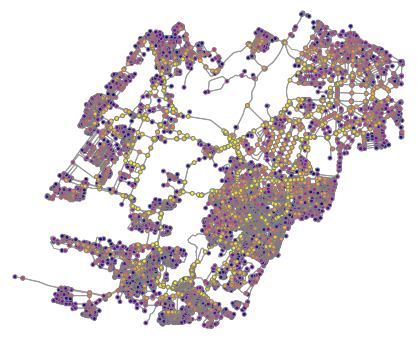

In [16]:
#getting a list of colors to attribute to and identify the top nodes in terms of betweenness centrality
def get_color_list(n, color_map='plasma', start=0, end=0.121902):
    return [cm.get_cmap(color_map)(x) for x in np.linspace(start, end, n)]

def get_node_colors_by_stat(G, data, start=0, end=1):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    df['colors'] = get_color_list(len(df), start=start, end=end)
    df = df.reindex(G_nx.nodes())
    return df['colors'].tolist()

nc = get_node_colors_by_stat(projected, data=extended_stats['betweenness_centrality'])
fig, ax = ox.plot_graph(projected, node_color=nc, node_edgecolor='gray', node_size=15, node_zorder=2)


In the above picture, I have color coded the intersections in the city of New Delhi, which are the nodes of the city network based on the betweenness centrality of each node. The betweenness centrality of a node is defined as " a measure of the influence of a vertex over the flow of information between every pair of vertices under the assumption that information primarily flows over the shortest paths between them". Hence, the nodes with higher betweenness centrality are yellow in color and are brighter, while the nodes with lower betweenness centrality are blue and darker in color.

In [17]:
def sort_nodes(data):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    return df

new_nodes = sort_nodes(data=extended_stats['betweenness_centrality'])
arr = new_nodes.index.tolist()

I remove the nodes with low betweennness centrality and choose the nodes with the top betwenness centrality measure to choose the locations wherein the Delhi Police CPR vans would be located.

In [18]:
G_nx.remove_nodes_from(arr[:7000])

In [19]:
G_nx.remove_nodes_from(list(nx.isolates(G_nx)))

In [20]:
# Generate connected components and select the largest:
largest_component = max(nx.strongly_connected_components(G_nx), key=len)

# Create a subgraph of G consisting only of this component:
G2 = G_nx.subgraph(largest_component)

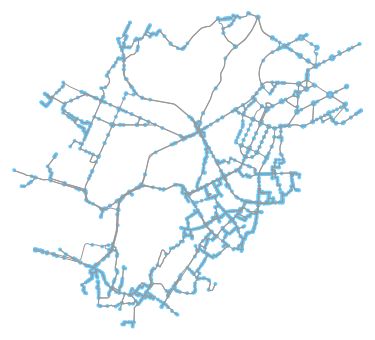

In [21]:
fig, ax = ox.plot_graph(G2)

In [22]:
G2.number_of_nodes()

2118

In [23]:
G2.number_of_edges()

3616

In [57]:
projected2 = ox.project_graph(G2)
G3 = nx.DiGraph(G2)

In [25]:
#getting a list of colors to attribute to and identify the top nodes in terms of betweenness centrality
def get_color_list(n, color_map='plasma', start=0, end=1):
    return [cm.get_cmap(color_map)(x) for x in np.linspace(start, end, n)]

def get_node_colors_by_stat(G, data, start=0, end=1):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    df['colors'] = get_color_list(len(df), start=start, end=end)
    df = df.reindex(G2.nodes())
    return df['colors'].tolist()

nc = get_node_colors_by_stat(projected2, data=extended_stats['betweenness_centrality'])
fig, ax = ox.plot_graph(projected2, node_color=nc, node_edgecolor='gray', node_size=15, node_zorder=2)



# The Simulation Rules

# Object Representation
In the simulation, I model two main elements which are integral to the functioning of the simulation. 

1. The City
I model the city of New Delhi using the OSMNX library through in which all the cities of the wolrd are modelled as a networkx graph.

2. The Police PCR Vehicle and the Criminal's Vehicle
I create a class called the vehicle class which holds the following information: the instantaneous speed of the car and the skillset of the driver. The class uses function definitions to calculate 
    1. the total average speed of the car during the journey, which is basically a product of the instantaneous speed of the car and the skillset of the driver.
    2. Shortest Path between the current location and destination
    3. The return path to the original location (police station)
    4. Amount of time taken to traverse the path, which is calculated by dividing the shortest path length given by the networkx function, by 1000 and multiplying it by 20 to get the time taken to traverse the shortest path.

1. The simulation works by first assigning a random location to the robber within the network. This is done by choosing a random node in the network through the random library. 
2. Then we calculate a bunch of exit nodes through which the robber would aim to exit the city, and select a random one amongst them setting it as the destination of the robber's car class. This simulates a real life scenario as the robber's decision would be uncertain.
3. We then calculate a bunch of nodes wherein there is a probability of the robber to show up based on the route pattern of the robber, and if they meet at the same node, the loop is broken and we publish the route. 
4. We optimize the path by. finding the starting position for the cops from where the route to catch the robber is the shortest.

# Python Implementation

In [95]:
def clear():
    os.system('clear')


def most_common(lst):
    return max(set(lst), key=lst.count)

In [96]:
class Car:
    def __init__(self, car_speed, driver_level):
        # Car speed is equal to max car speed in km/h
        self.car_speed = car_speed
        # Driver level from 0 to 1 exmpl 0.58
        self.driver_level = driver_level

    def callculateActualSpeed(self):
        return self.car_speed * self.driver_level

    def ShowShortestPath(self, G, origin_p, destination_p, isPolice=False, multi=1):

        # Creating shortest path based on length
        route = nx.shortest_path(G, origin_p, destination_p, weight='length')
        # Plotting route
        if isPolice:
            fig, ax = ox.plot_graph_route(G, route, route_color='Blue', orig_dest_node_size=15 * multi, orig_dest_node_color="Blue",
                                          orig_dest_point_color="Blue")
        else:
            fig, ax = ox.plot_graph_route(G, route, route_color='Red', orig_dest_node_size=15 * multi, orig_dest_node_color="Red",
                                          orig_dest_point_color="Red")

    def returnRoute(self, G, origin_p, destination_p):
        # Creating shortest path based on length
        route = nx.shortest_path(G, origin_p, destination_p, weight='length')
        return route

    def calculatePathTime(self, G, route, origin_p,):

        # Creating list and adding zero index
        route_times = [0]
        for n in range(1, len(route)):
            route_times.append((nx.shortest_path_length(
                G, origin_p, route[n], weight='length') / 1000) * 60 / 5)
        return route_times

    def pathTime(self, G, origin_p, destination_p):
        return nx.shortest_path_length(G, origin_p, destination_p, weight='length') / 1000 * 60 / 5

Starting node id:  8104


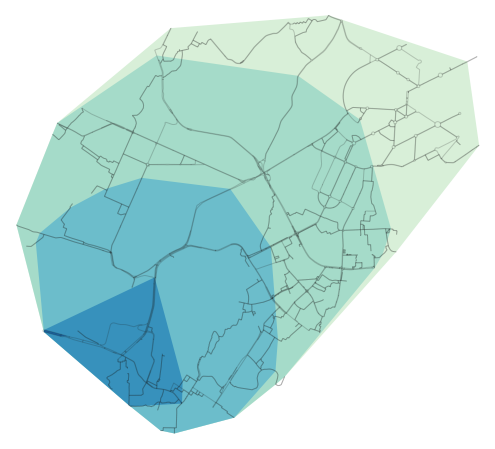

In [126]:
import random
r1 = Car(50, 0.25)

x = random.randint(0,100)
y = random.randint(0,100)

starting_node = ox.get_nearest_node(G2, (2, 50))
print("Starting node id: ", starting_node)

list_of_ints = list(range(1, 25, 5))
escape_time = list_of_ints

meters_per_minute = r1.car_speed * 1000 / 60
for u, v, k, data in G2.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute
    
iso_colors = ox.get_colors(
    n=len(escape_time), cmap='GnBu', start=0.3, return_hex=True)

isochrone_polys = []
for trip_time in sorted(escape_time, reverse=True):
    subgraph = nx.ego_graph(
        G2, starting_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y']))
                   for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
    
fig, ax = ox.plot_graph(G2, fig_height=8, show=False, close=False,
                        edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

In [119]:
import random
r1 = Car(50, 0.25)

x = random.choice([G2.nodes[osmid]['x'] for osmid in G2.nodes])
y = random.choice([G2.nodes[osmid]['y'] for osmid in G2.nodes])

starting_node = ox.get_nearest_node(G2, (x, y))
print("Starting node id: ", starting_node)

list_of_ints = list(range(1, 25, 5))
escape_time = list_of_ints

meters_per_minute = r1.car_speed * 1000 / 60
for u, v, k, data in G2.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute
    
iso_colors = ox.get_colors(
    n=len(escape_time), cmap='GnBu', start=0.3, return_hex=True)

isochrone_polys = []
for trip_time in sorted(escape_time, reverse=True):
    subgraph = nx.ego_graph(
        G2, starting_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y']))
                   for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
    
fig, ax = ox.plot_graph(G2, fig_height=8, show=False, close=False,
                        edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

Starting node id:  2562


Starting node id:  1849
Do you want to enter more exit nodes ? [y],[n]: n
Exit nodes count:  200
Destination node id:  871
Path length: 4.1559610000000005 km!
Proceed? [y],[n]: y


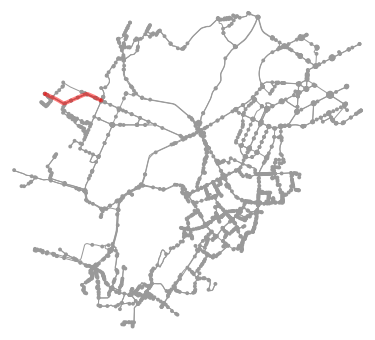

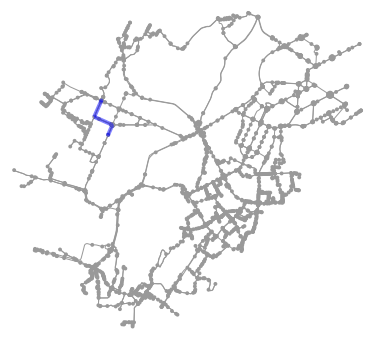

Proceed? [y],[n]: y


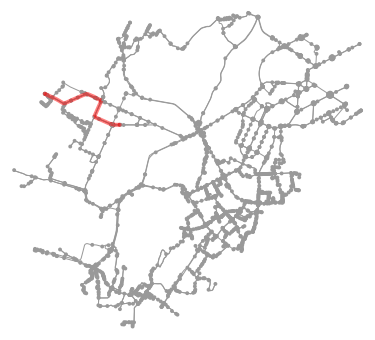

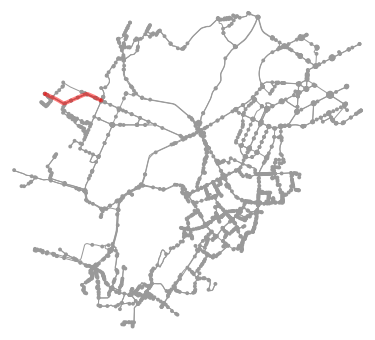

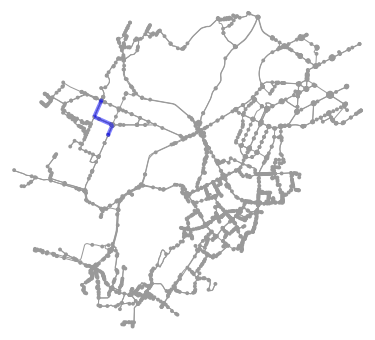

Proceed? [y],[n]: y


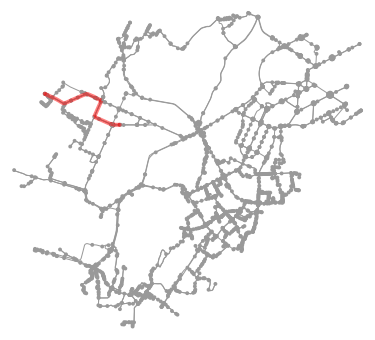

Proceed? [y],[n]: y


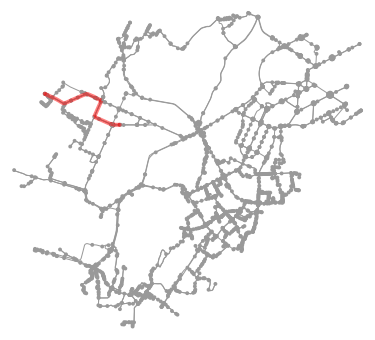

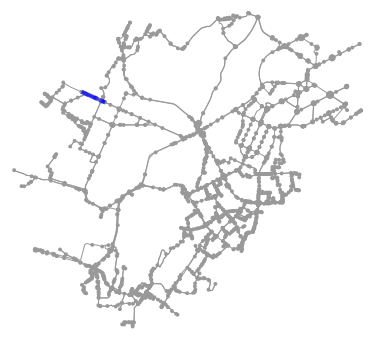

Proceed? [y],[n]: y


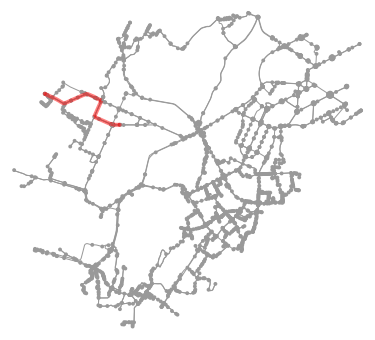

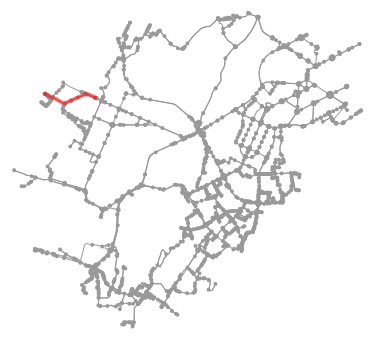

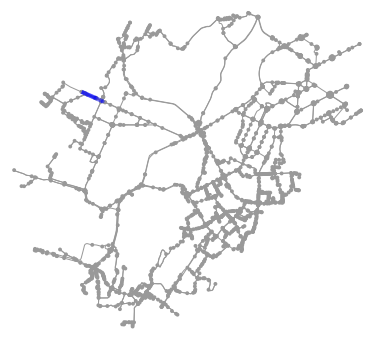

Proceed? [y],[n]: y


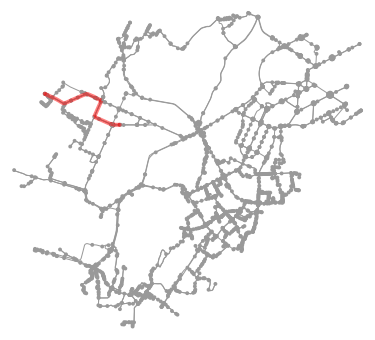

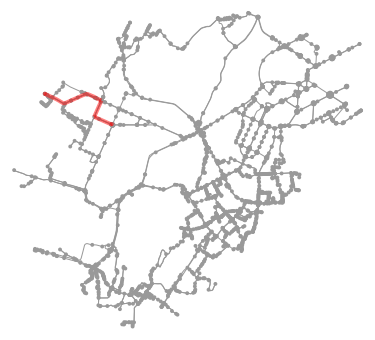

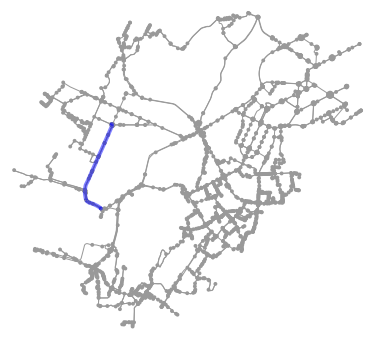

Proceed? [y],[n]: y


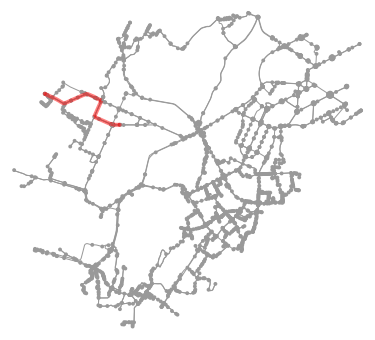

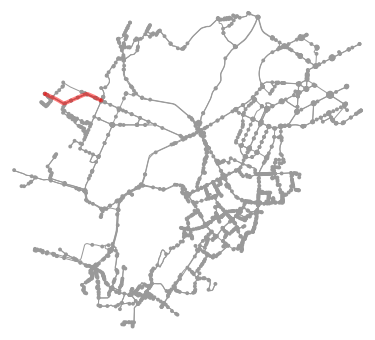

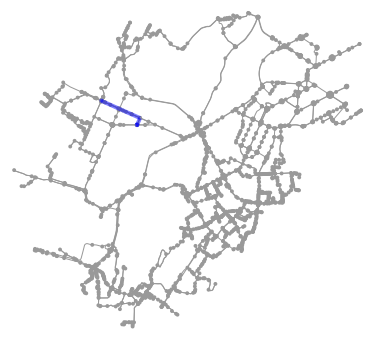

Proceed? [y],[n]: y


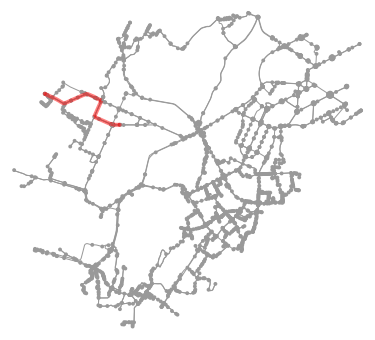

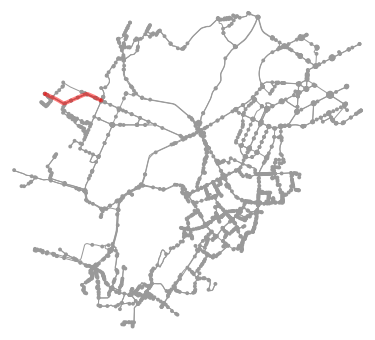

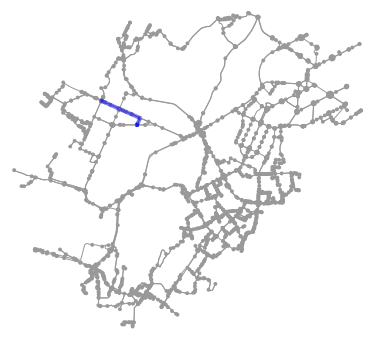

Proceed? [y],[n]: y


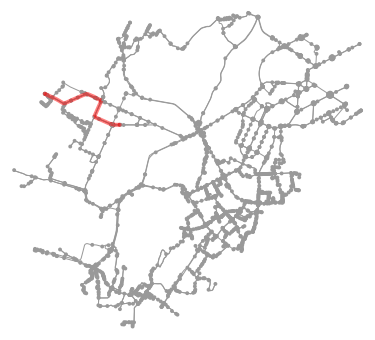

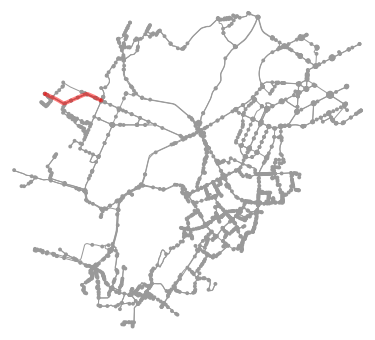

Proceed? [y],[n]: y


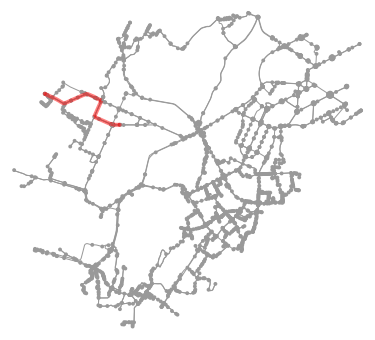

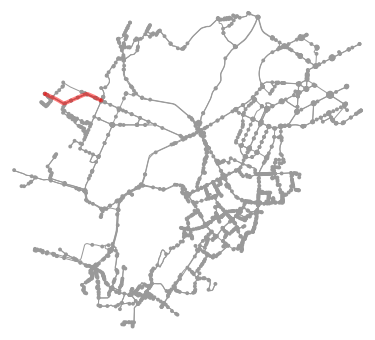

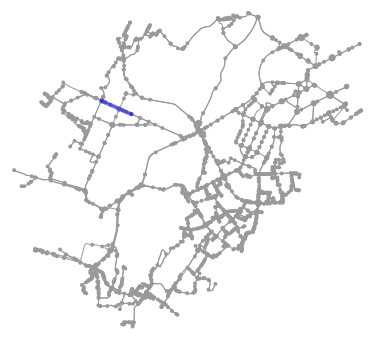

Proceed? [y],[n]: y


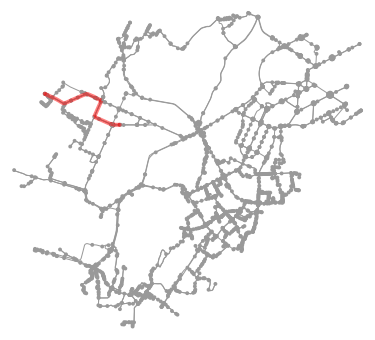

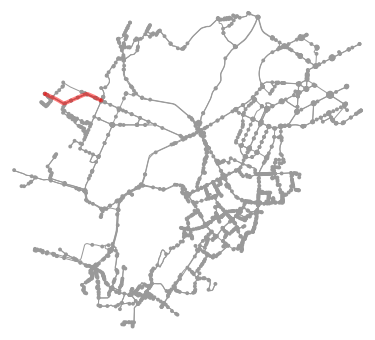

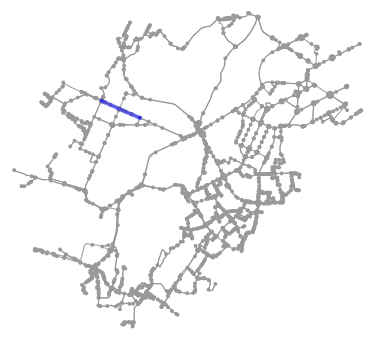

Proceed? [y],[n]: y


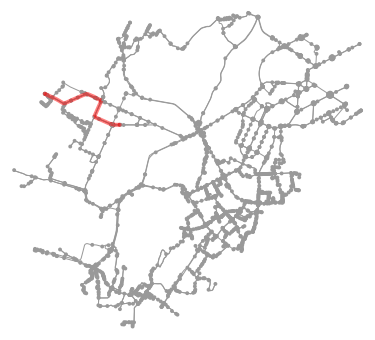

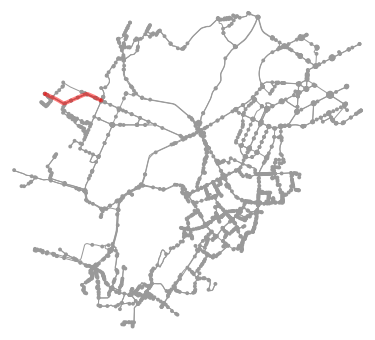

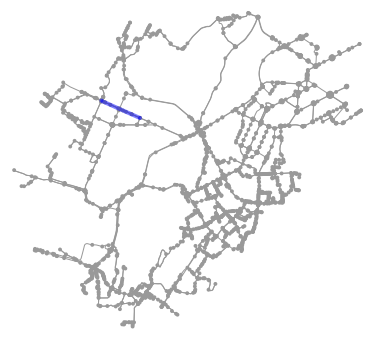

Proceed? [y],[n]: y


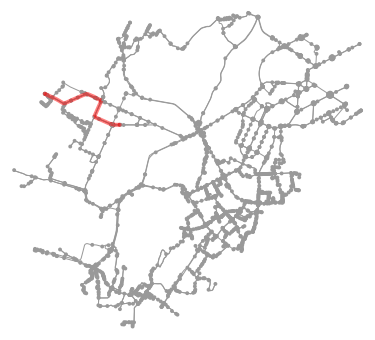

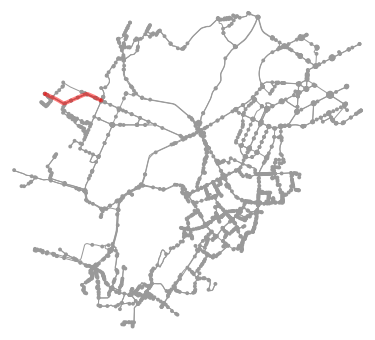

Proceed? [y],[n]: y


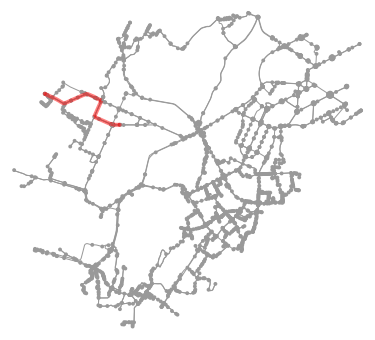

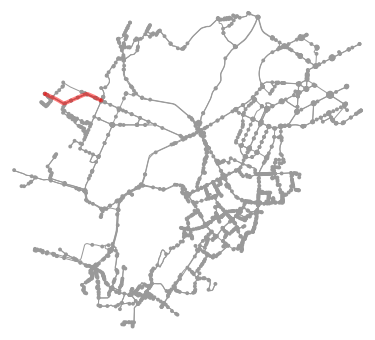

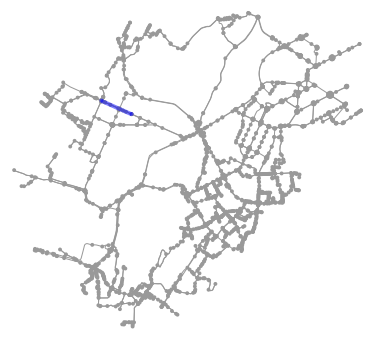

Proceed? [y],[n]: y


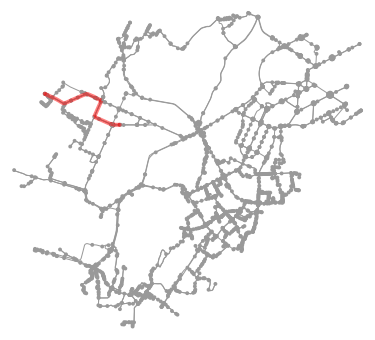

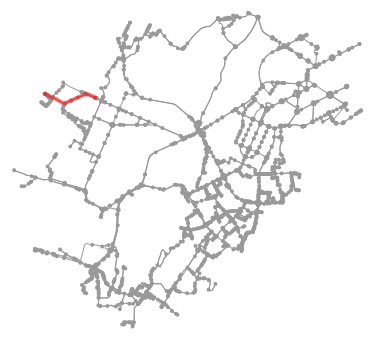

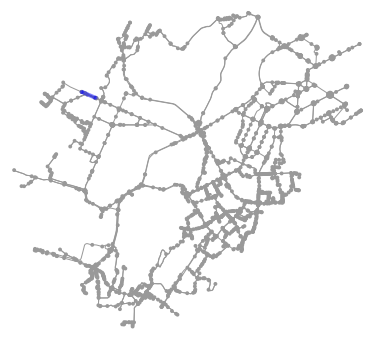

Proceed? [y],[n]: y


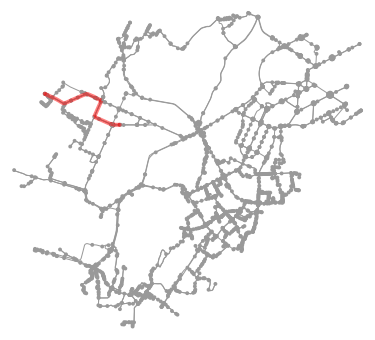

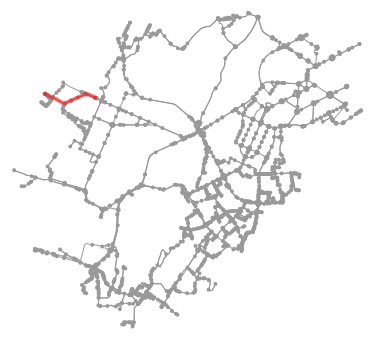

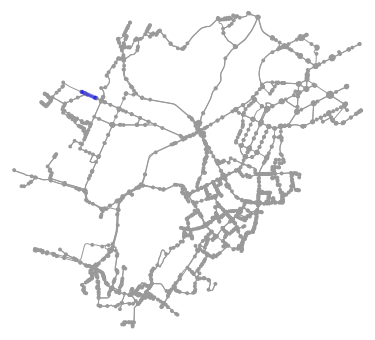

Proceed? [y],[n]: y


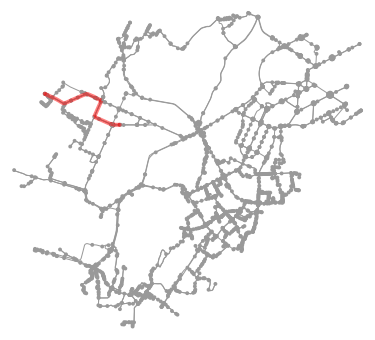

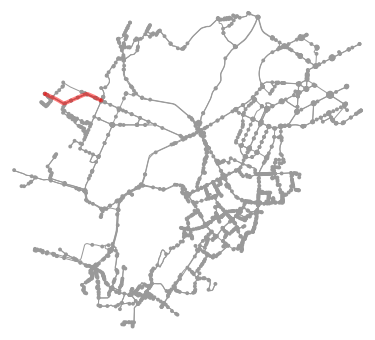

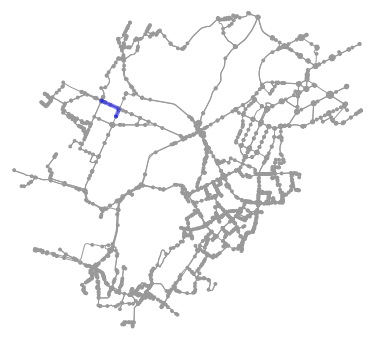

Proceed? [y],[n]: y


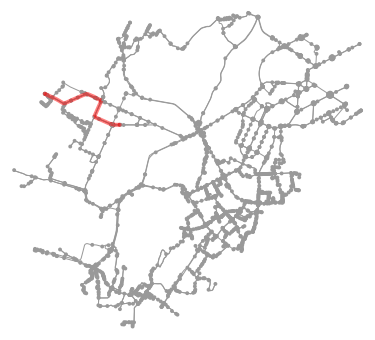

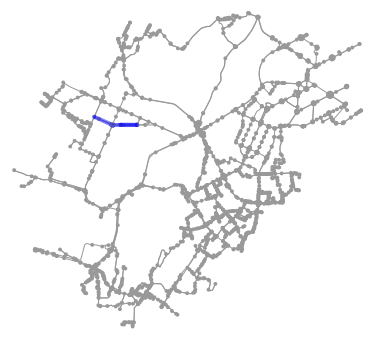

Proceed? [y],[n]: y


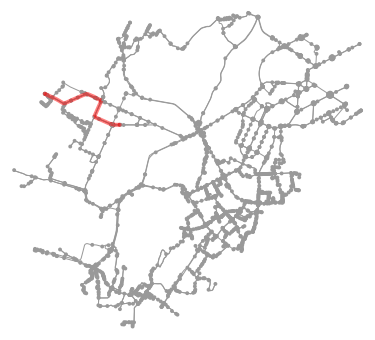

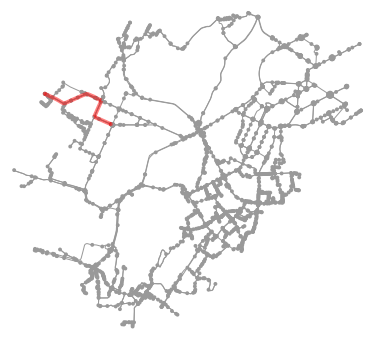

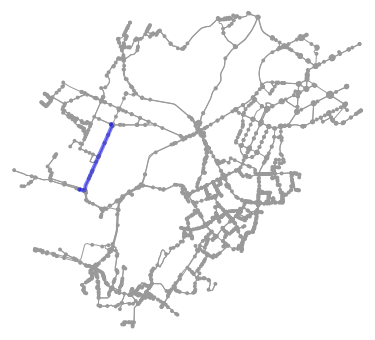

Proceed? [y],[n]: y


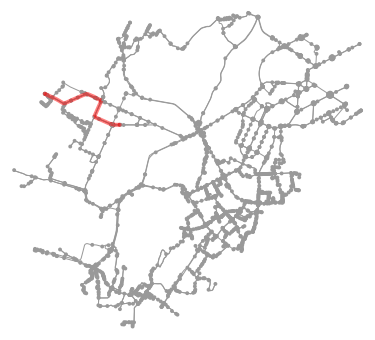

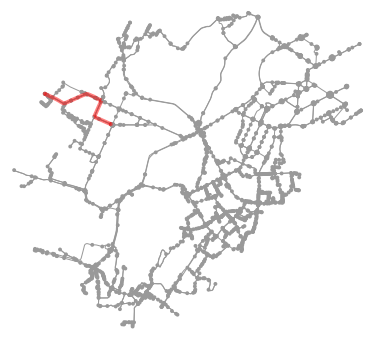

Proceed? [y],[n]: y


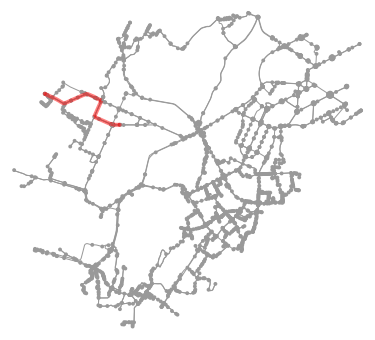

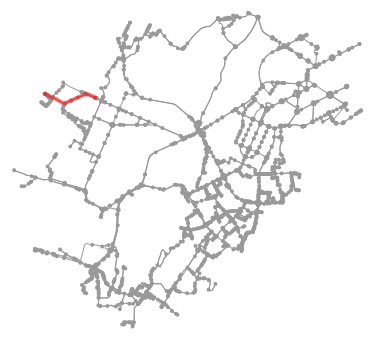

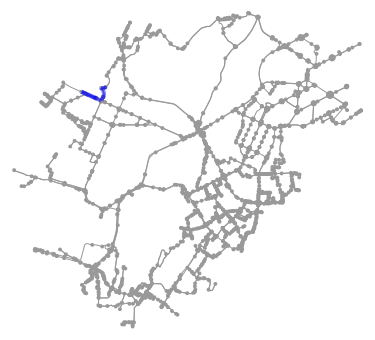

Proceed? [y],[n]: y


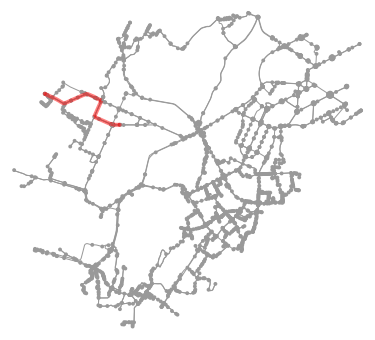

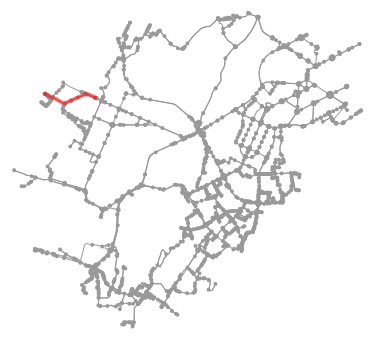

Proceed? [y],[n]: y


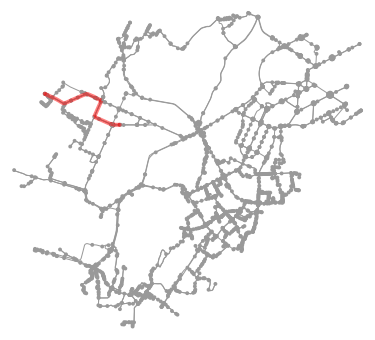

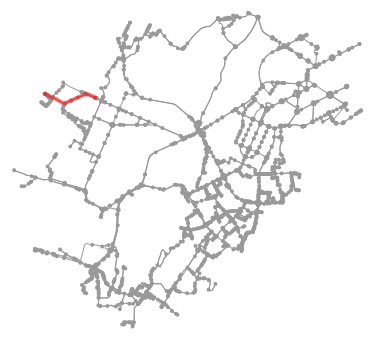

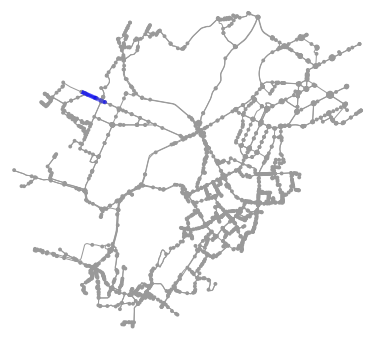

Proceed? [y],[n]: y


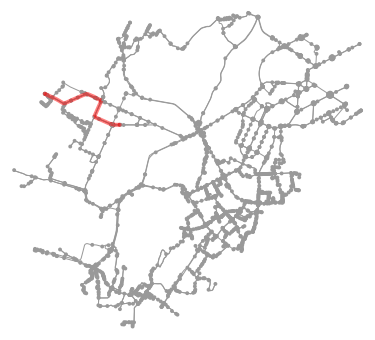

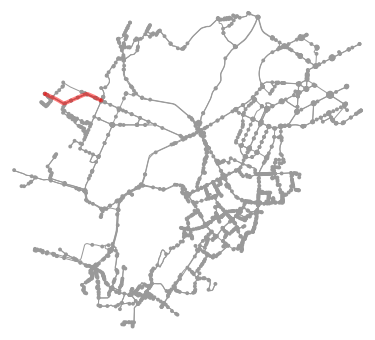

Proceed? [y],[n]: y


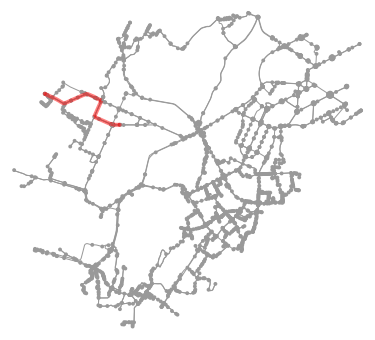

Proceed? [y],[n]: y


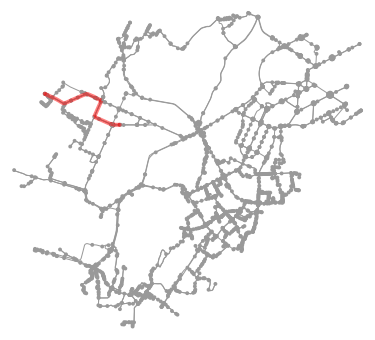

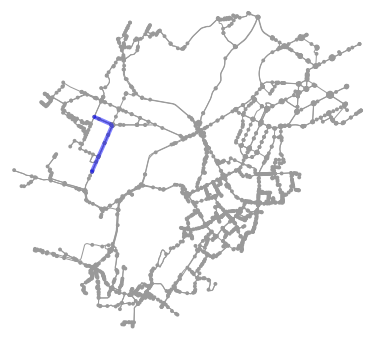

Proceed? [y],[n]: y


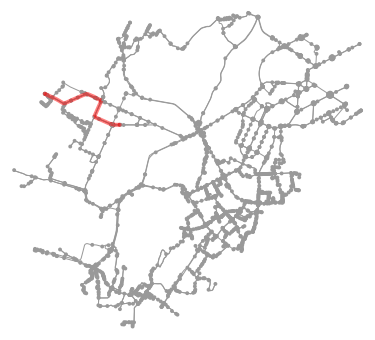

Proceed? [y],[n]: y


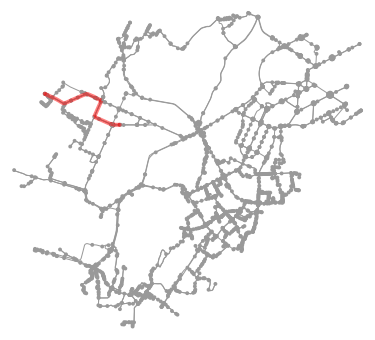

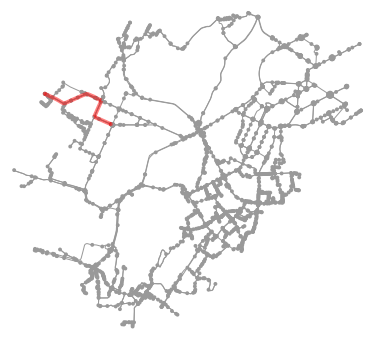

Proceed? [y],[n]: y


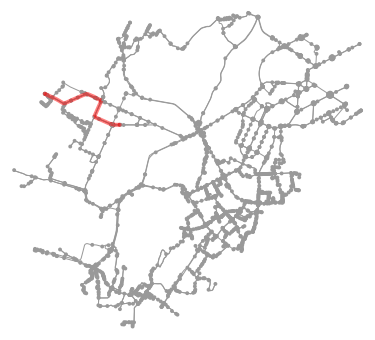

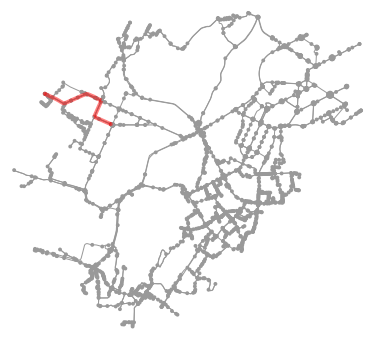

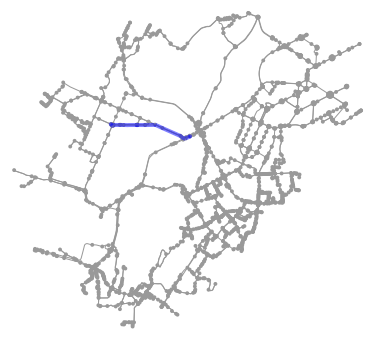

Proceed? [y],[n]: y


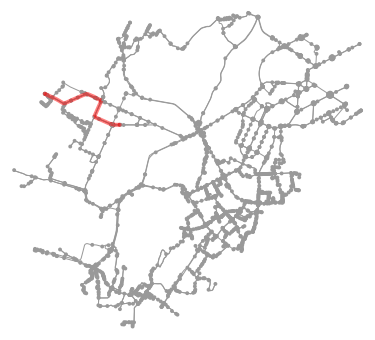

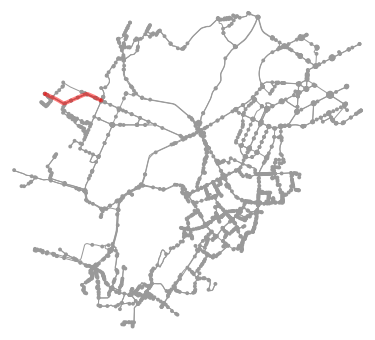

Proceed? [y],[n]: y


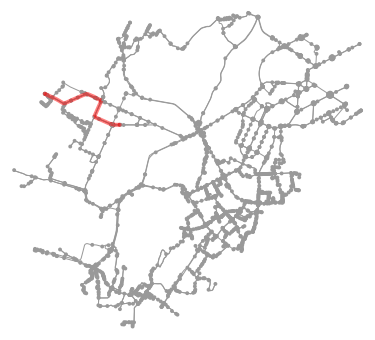

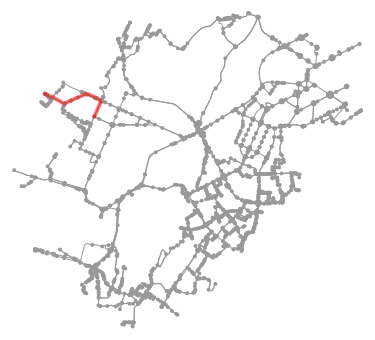

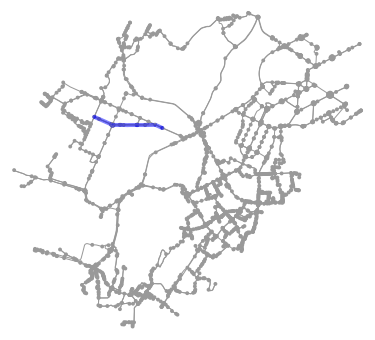

Proceed? [y],[n]: y


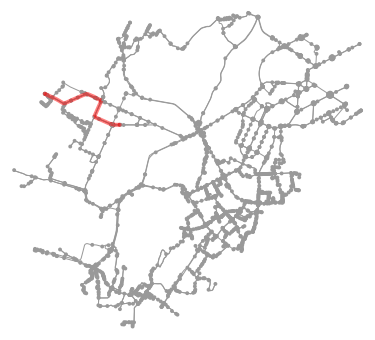

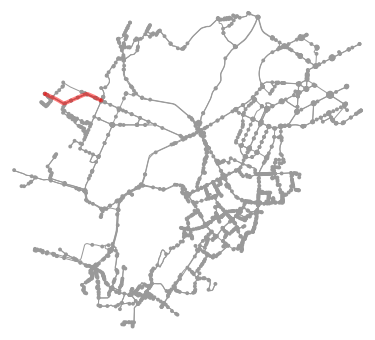

Proceed? [y],[n]: y


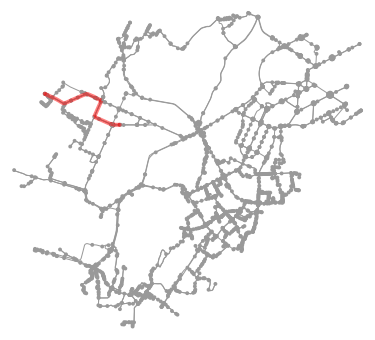

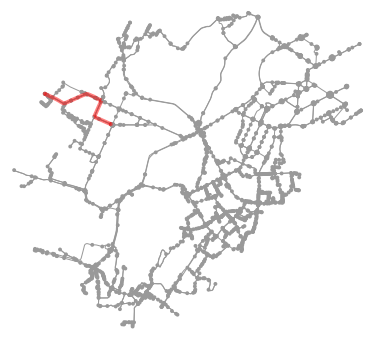

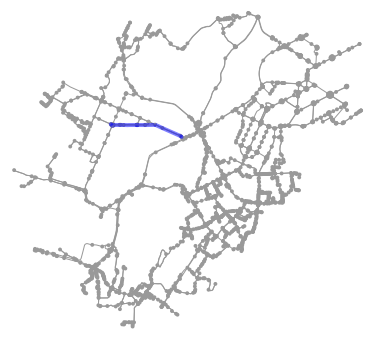

Proceed? [y],[n]: 
Best starting point for police: 


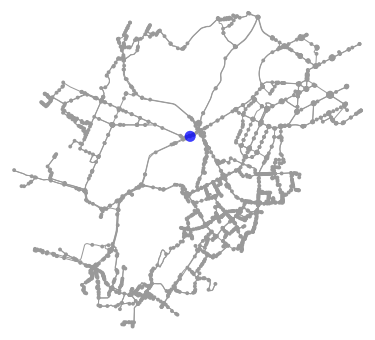

In [110]:
import random

p1, r1 = Car(20, 1), Car(20, 0.25)
x = random.choice([G2.nodes[osmid]['x'] for osmid in G2.nodes])
y = random.choice([G2.nodes[osmid]['y'] for osmid in G2.nodes])

starting_node = ox.get_nearest_node(G2, (x, y))
print("Starting node id: ", starting_node)

exit_nodes = []
for x in G2.nodes():
        if len(exit_nodes) >= 200:
            break
        if nx.degree(G2, x) == 2 and nx.has_path(G2, starting_node, x) == True:
            exit_nodes.append(x)

clear()
print("Exit nodes count: ", len(exit_nodes))

# Randomly setting destination node for robber
destination_node = choice(exit_nodes)
while nx.has_path(G2, starting_node, destination_node) == False:
    destination_node = choice(exit_nodes)

print("Destination node id: ", destination_node)

# Printing length of route in kilometeres
print("Path length: %s km!" % (nx.shortest_path_length(G2, starting_node, destination_node, weight='length') / 1000)
)
# Calculation path times
path_times = r1.calculatePathTime(G2, r1.returnRoute(
    G2, starting_node, destination_node), starting_node)

# Creating best nodes array and defining route from return route
best_nodes = []
route = r1.returnRoute(G2, starting_node, destination_node)


for m in G2.nodes():
    if len(best_nodes) >= 50:
        break
    # If node is in route we need to delete it
    if m in r1.returnRoute(G2, starting_node, destination_node):
        continue
    else:
        for n in range(0, len(r1.returnRoute(G2, starting_node, destination_node))):
            if nx.has_path(G2, m, route[n]) == True:
                if p1.pathTime(G2, m, route[n]) <= path_times[n]:
                    best_nodes.append((m, route[n]))
                    # if we find good one we won't to exit second loop
                    break

for b in best_nodes:
    if input("Proceed? [y],[n]: ") == 'y':
        # Showing full robbers path
        r1.ShowShortestPath(G2, starting_node, destination_node)
        # Showing break point of robbers
        r1.ShowShortestPath(G2, starting_node, b[1])
        # Showing break point of police
        p1.ShowShortestPath(G2, b[0], b[1], 1)
        clear()
    else:
        break

b = most_common(best_nodes)

print("Best starting point for police: ")
r1.ShowShortestPath(G2, starting_node, starting_node, False, 8)
p1.ShowShortestPath(G2, b[0], b[0], True, 8)

In [26]:
extended_stats2 = ox.extended_stats(G2, bc=True)

# Simulation
Since this code deals with around 3000 nodes and around 7000 edges, the simulations take a long time to run on the laptop. Hence, I have used google collab's high ram (25 GB) paid service to run the simulations and analyze the result. The aforementioned code only optimize the positioning of two police officers, but the simulations in the colab notebook runs its for 10 police officers. The code can be found at: https://colab.research.google.com/drive/1cs8WUTfIjYSTlxMh10pOomAlsf8N3m3A